In [1]:
#Activating this will give extra control over the plots in jupyter-notebook when executing
#%matplotlib notebook
%matplotlib inline
#TODO: Jupyter-lab
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import skfmm
import matplotlib.pyplot as plt
from utils import * #Utility functions defined in a separate file to keep the code short
velocity_func = lambda x, s=2.9: 1. / (s + np.sin(x[..., 0]) + np.cos(x[..., 1]))

# Parameters

In [2]:
grid_resolution = 75
grid_extent = 20

In [3]:
grid_x = np.linspace(0, grid_extent, num=grid_resolution)
grid = np.stack(np.meshgrid(grid_x, grid_x, indexing='ij'), axis=-1)
grid_flat = grid.reshape([-1, 2])
vel_field = np.sqrt(velocity_func(grid))
dx = grid[1, 0, 0] - grid[0, 0, 0]

/home/thomas/anaconda3/envs/geasi_grid_demo/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


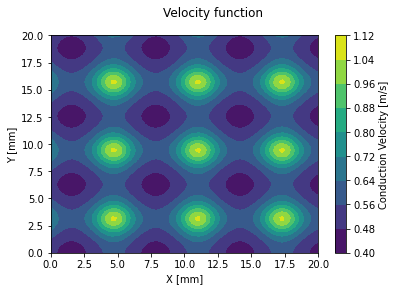

In [4]:
fig = plt.figure()
plt.contourf(grid[..., 0], grid[..., 1], vel_field)
fig.suptitle("Velocity function")
cbar = plt.colorbar()
cbar.set_label("Conduction Velocity [m/s]")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
fig.show()

In [5]:
#Create the measurement domain
gamma = np.any(np.isclose(grid, 0.) | np.isclose(grid, grid_extent), axis=-1)
gamma_flat = np.any(np.isclose(grid_flat, 0.) | np.isclose(grid_flat, grid_extent), axis=-1)
#Initialize
xi_init = np.array([[grid_extent/3, grid_extent/3], [grid_extent/2, grid_extent/2]])
ti_init = np.array([0., -1.])
xi_ground_truth = np.array([[3/4 * grid_extent, 3/4 * grid_extent], [1/4 * grid_extent, 1/4 * grid_extent]])
ti_ground_truth = np.array([2., 5.])

# Constraints

In [6]:
t_bounds = [-1., 10.]
xi_bounds = np.stack([[0., 0.], [grid_extent, grid_extent]])
proj_op = lambda x: np.minimum(grid_extent, np.maximum(0., x))

# Setup

/home/thomas/anaconda3/envs/geasi_grid_demo/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


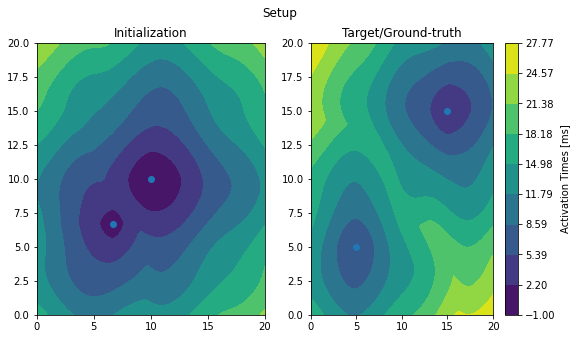

In [7]:
phi_init = computeEikonal(xi_init, ti_init, grid, vel_field)
phi_ground_truth = computeEikonal(xi_ground_truth, ti_ground_truth, grid, vel_field)
level_lines = np.linspace(np.min(phi_init), np.max(phi_ground_truth), num=10)
nabla_phi_init = computeEikonalGradient(phi_init, grid, vel_field)
nabla_phi_gt = computeEikonalGradient(phi_ground_truth, grid, vel_field)
subsampling = grid_resolution // 25
grid_subsampled = grid[::subsampling, ::subsampling]

fig, axes = plt.subplots(ncols=2, nrows=1)
fig.suptitle("Setup")
axes[0].contourf(grid[..., 0], grid[..., 1], phi_init, level_lines)
axes[0].scatter(xi_init[..., 0], xi_init[..., 1])
axes[0].set_title("Initialization")

gt_p = axes[1].contourf(grid[..., 0], grid[..., 1], phi_ground_truth, level_lines)
axes[1].scatter(xi_ground_truth[..., 0], xi_ground_truth[..., 1])
#axes[1].quiver(grid_subsampled[..., 0], grid_subsampled[..., 1], 
#               nabla_phi_gt[::subsampling, ::subsampling, 0], nabla_phi_gt[::subsampling, ::subsampling, 1])
axes[1].set_title("Target/Ground-truth")
cbar = plt.colorbar(gt_p)
cbar.set_label("Activation Times [ms]")
fig.set_size_inches((9, 5))
fig.show()

/home/thomas/anaconda3/envs/geasi_grid_demo/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


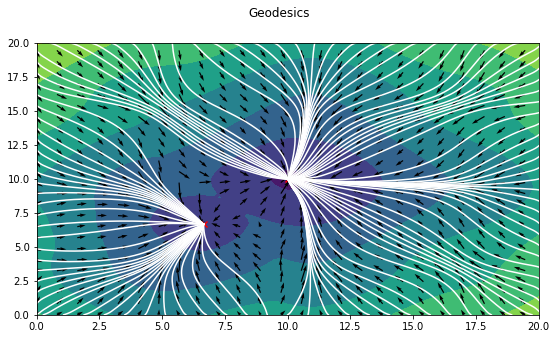

In [8]:
geodesics = computeGeodesics(nabla_phi_init, grid, grid[gamma], proj_op, alpha=1e-1)

fig = plt.figure()
fig.suptitle("Geodesics")
plt.contourf(grid[..., 0], grid[..., 1], phi_init)
plt.quiver(grid_subsampled[..., 0], grid_subsampled[..., 1], 
               nabla_phi_init[::subsampling, ::subsampling, 0], nabla_phi_init[::subsampling, ::subsampling, 1])
plt.plot(geodesics[:, ::subsampling, 0], geodesics[:, ::subsampling, 1], color='w', alpha=1.)
plt.scatter(xi_init[..., 0], xi_init[..., 1], marker='x', color='r')
#plt.scatter(geodesics[-1, ::subsampling, 0], geodesics[-1, ::subsampling, 1], color='g', marker='o', alpha=1.)
fig.set_size_inches((9, 5))
fig.show()

/home/thomas/anaconda3/envs/geasi_grid_demo/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


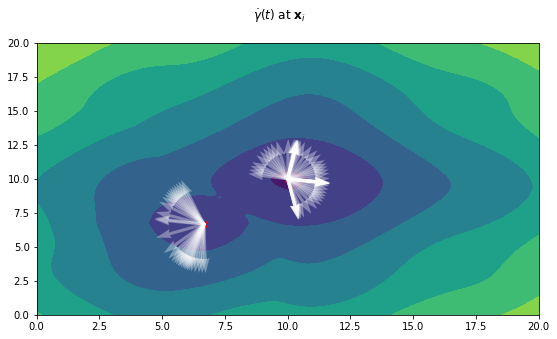

In [9]:
gamma_dot_converg, jacobian_opt = compSourceGradients(geodesics, xi_init, grid, -nabla_phi_init,
                                                     vel_field, neighborhood_eps=dx/2.)
xi_broadcast = np.tile(xi_init, [jacobian_opt.shape[0], 1, 1])
fig = plt.figure()
fig.suptitle("$\dot{\gamma}(t)$ at $\mathbf{x}_i$")
plt.contourf(grid[..., 0], grid[..., 1], phi_init)
plt.scatter(xi_init[..., 0], xi_init[..., 1], marker='x', color='r')
plt.quiver(xi_broadcast[::subsampling, 0, 0], xi_broadcast[::subsampling, 0, 1], 
           jacobian_opt[::subsampling, 0], jacobian_opt[::subsampling, 1], 
           color='w', alpha=.35, scale=5)
plt.quiver(xi_broadcast[::subsampling, 1, 0], xi_broadcast[::subsampling, 1, 1], 
           jacobian_opt[::subsampling, 2], jacobian_opt[::subsampling, 3], 
           color='w', alpha=.35, scale=10)
fig.set_size_inches((9, 5))
fig.show()

In [10]:
errors = []
xi_current = xi_init
ti_current = ti_init
nr_xi = ti_current.size
print_modulo = 1
for opt_iter in range(50):    
    phi_current = computeEikonal(xi_current, ti_current, grid, vel_field)
    nabla_phi_current = computeEikonalGradient(phi_current, grid, vel_field)
    geodesics = computeGeodesics(nabla_phi_current, grid, grid[gamma], proj_op, alpha=1e-1)
    gamma_dot_converg, jacobian_opt = compSourceGradients(geodesics, xi_current, grid, nabla_phi_current,
                                                     vel_field, neighborhood_eps=dx/2.)
    
    #Least squares problem (Gauss-Newton)
    residuals = phi_current[gamma] - phi_ground_truth[gamma]
    x0 = np.concatenate([xi_current.reshape([-1], order='C'), ti_current])
    quadr_f = lambda x: 0.5 * np.sum((jacobian_opt @ (x - x0) + residuals)**2)
    quadr_grad = lambda x: jacobian_opt.T @ (jacobian_opt @ (x - x0) + residuals)
    bfgs_result = fmin_l_bfgs_b(quadr_f, x0, fprime=quadr_grad, 
                  bounds=((0, grid_extent),) * nr_xi * 2 + ((t_bounds[0], t_bounds[1]),) * nr_xi)
    
    x_new = x0 + 0.5 * (bfgs_result[0] - x0)
    xi_current = x_new[:nr_xi*2].reshape([nr_xi, 2], order='C')
    ti_current = x_new[nr_xi*2:]
    
    
    if opt_iter % print_modulo == 0:
        error_gamma = .5 * np.sum(residuals**2)
        error_omega = .5 * np.sum((phi_current - phi_ground_truth)**2)
        print("Iteration %d, SSE (Gamma): %.2e, SSE (Omega): %.2e" % (opt_iter, error_gamma, error_omega))

Iteration 0, SSE (Gamma): 3.35e+03, SSE (Omega): 1.13e+05
Iteration 1, SSE (Gamma): 1.35e+03, SSE (Omega): 2.95e+04
Iteration 2, SSE (Gamma): 5.16e+02, SSE (Omega): 5.98e+03
Iteration 3, SSE (Gamma): 4.44e+01, SSE (Omega): 5.21e+02
Iteration 4, SSE (Gamma): 3.03e+00, SSE (Omega): 5.72e+01
Iteration 5, SSE (Gamma): 7.41e-01, SSE (Omega): 1.43e+01
Iteration 6, SSE (Gamma): 1.81e-01, SSE (Omega): 3.57e+00
Iteration 7, SSE (Gamma): 4.60e-02, SSE (Omega): 9.24e-01
Iteration 8, SSE (Gamma): 1.16e-02, SSE (Omega): 2.37e-01
Iteration 9, SSE (Gamma): 3.02e-03, SSE (Omega): 6.20e-02
Iteration 10, SSE (Gamma): 7.76e-04, SSE (Omega): 1.58e-02
Iteration 11, SSE (Gamma): 2.02e-04, SSE (Omega): 4.01e-03
Iteration 12, SSE (Gamma): 5.04e-05, SSE (Omega): 9.96e-04
Iteration 13, SSE (Gamma): 1.28e-05, SSE (Omega): 2.52e-04
Iteration 14, SSE (Gamma): 3.17e-06, SSE (Omega): 6.23e-05
Iteration 15, SSE (Gamma): 7.87e-07, SSE (Omega): 1.59e-05
Iteration 16, SSE (Gamma): 1.88e-07, SSE (Omega): 4.60e-06
Iterati

/home/thomas/anaconda3/envs/geasi_grid_demo/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


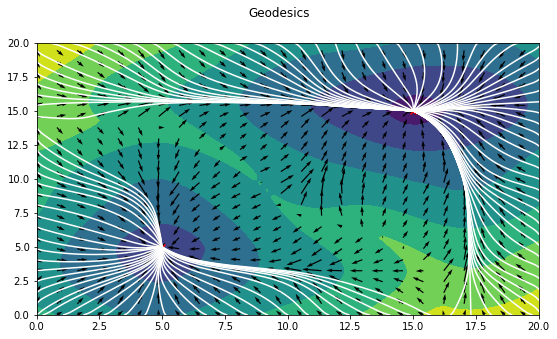

In [11]:
geodesics = computeGeodesics(nabla_phi_current, grid, grid[gamma], proj_op, alpha=1e-1)

fig = plt.figure()
fig.suptitle("Geodesics")
plt.contourf(grid[..., 0], grid[..., 1], phi_current)
plt.quiver(grid_subsampled[..., 0], grid_subsampled[..., 1], 
               nabla_phi_current[::subsampling, ::subsampling, 0], nabla_phi_current[::subsampling, ::subsampling, 1])
plt.plot(geodesics[:, ::subsampling, 0], geodesics[:, ::subsampling, 1], color='w', alpha=1.)
plt.scatter(xi_current[..., 0], xi_current[..., 1], marker='x', color='r')
#plt.scatter(geodesics[-1, ::subsampling, 0], geodesics[-1, ::subsampling, 1], color='g', marker='o', alpha=1.)
fig.set_size_inches((9, 5))
fig.show()

In [ ]:
xi_init

In [ ]:
geodesics = computeGeodesics(nabla_phi_init, grid, grid[gamma], proj_op, alpha=2.5e-2)

In [ ]:
#plt.figure()
#plt.plot(geodesics[..., 0], geodesics[..., 1])

In [ ]:
nabla_phi_converg[0], jacobian[0], source_geodesic_valid.shape, jacobian.shape

In [ ]:
source_geodesic_valid